<H1>Feature Transformation Cheatsheet</H1>

<H3>1. Introduction</H3>

Feature transformation can bring a significant improvement to your model. Sometimes feature transformation is the only way to gain a better score, so it is a crucial point how you represent your data and feed it to a target model. In this article, I go through some common data types and analyze various data transformations. For these purposes, I am going to use a [GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv](https://data.world/data-society/global-climate-change-data#) dataset which represents global climate changes from 1750 to 2015 years.

This dataset consists of very frequent feature types such as date, location, numerical and categorical columns. In this review, we will save for later a discussion about feature selection and various angles of feature engineering, as here we have a straight focus on possible ways of encoding such data. It is supposed to be a cheatsheet template that one might use when dealing with feature transformations in similar cases.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import time
import random
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,5)})


from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from collections import ChainMap
from pyproj import Proj, Transformer
from google_trans_new import google_translator  
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


print('Pandas version: ', pd.__version__)


#reading the dataset
df = pd.read_csv('data/GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv')

Pandas version:  1.3.4


In [2]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E


As a starting point, here is a quick look at the overall dataset statistics:

In [3]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,228175.000000,228175.000000
mean,18.125969,0.969343
std,10.024800,0.979644
min,-26.772000,0.040000
25%,12.710000,0.340000
50%,20.428000,0.592000
75%,25.918000,1.320000
max,38.283000,14.037000


The 'include' is the argument which is used to pass necessary information regarding what columns need to be considered for summarizing. Takes the list of values; by default, 'number'.

object − Summarizes String columns

number − Summarizes Numeric columns

all − Summarizes all columns together (Should not pass it as a list value)

In [4]:
df.describe(include=['object'])

,dt,City,Country,Latitude,Longitude
count,239177,239177,239177,239177,239177
unique,3239,100,49,49,93
top,1983-12-01,Rome,India,31.35N,31.38E
freq,100,3239,36582,13875,6801


Note that df.info() provides counts of non-null values for each column. This tells you if there are any null values in the columns. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


In [6]:
# any rows duplicated ?
df.duplicated().any()

False

In [7]:
# check overall stats on your dataset
def show_stats(df):
    print(df.describe())
    for column in list(df.columns):
        print(column, '| Data type: ', df[column].dtype, '| Null values: ', df[column].isnull().sum(), round(df[column].isnull().sum()/len(df)*100, 2), '%', '| Numer of unique values: ',  len(np.unique(list(df[column].astype(str)))))
        print()


In [8]:
show_stats(df)

       AverageTemperature  AverageTemperatureUncertainty
count       228175.000000                  228175.000000
mean            18.125969                       0.969343
std             10.024800                       0.979644
min            -26.772000                       0.040000
25%             12.710000                       0.340000
50%             20.428000                       0.592000
75%             25.918000                       1.320000
max             38.283000                      14.037000
dt | Data type:  object | Null values:  0 0.0 % | Numer of unique values:  3239

AverageTemperature | Data type:  float64 | Null values:  11002 4.6 % | Numer of unique values:  52369

AverageTemperatureUncertainty | Data type:  float64 | Null values:  11002 4.6 % | Numer of unique values:  6270

City | Data type:  object | Null values:  0 0.0 % | Numer of unique values:  100

Country | Data type:  object | Null values:  0 0.0 % | Numer of unique values:  49

Latitude | Data type:  o

We can see that the dataset has no duplicated rows. Here are only two numerical features of type float64 and the rest are object types (some of them have to be converted to exact type). We can see that only these two numerical features AverageTemperature and AverageTemperatureUncertainty have 11002 null values each. And general statistics for these temperature values:



<H3>2. Imputation of Missing Values</H3>

First of all, let’s deal with missing values. It is a very common case where data has blank fields, random characters, and even wrong information. Here we suppose we have a more or less cleaned dataset with some null values. If you have some idea about your dataset and knowledge of where these missing values come from, then it would be easier for you to guess how to treat them.

On the other hand, in loads of cases, you are not sure and have to choose a method to fix your missing values. Why should we pay attention to that? The simple answer is that not every machine learning algorithm can manage missing values. Another point of view is that with proper imputation/deletion you again can gain a better result. Here are few ideas to transform your missing values into something more informative:


A Boxplot depicts the distribution of quantitative data facilitating comparisons between different variables, continuous or categorical. It is a common data dispersion measure. Boxplots consist of a five-number summary which helps in detecting and removing outliers from the dataset.

- Minimum observation
- Q1 (25% or Quartile 1)
- Median or Q2
- Q3 (75% or Quartile 2)
- Maximum Observation

NOTE that the data is dispersed around the median, which is how outliers can be identified.

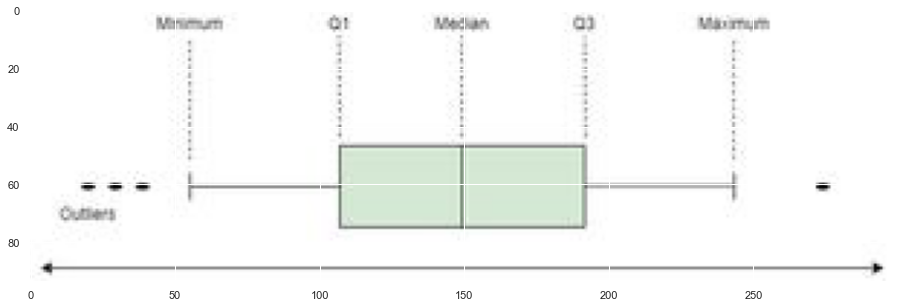

In [9]:
import matplotlib.image as mpimg

img = mpimg.imread('./BoxplotGFG-300x94.jpg')
imgplot = plt.imshow(img)
plt.show()

One way to go is to impute these missing values with median, mean, or mode (most frequent value). To choose between these three just take a look at a boxplot and distribution. If your data distributed symmetrically, then replacing missing data with mean might be a good idea. If your data is skewed or contains outliers, try to look into the mode or median imputation options.

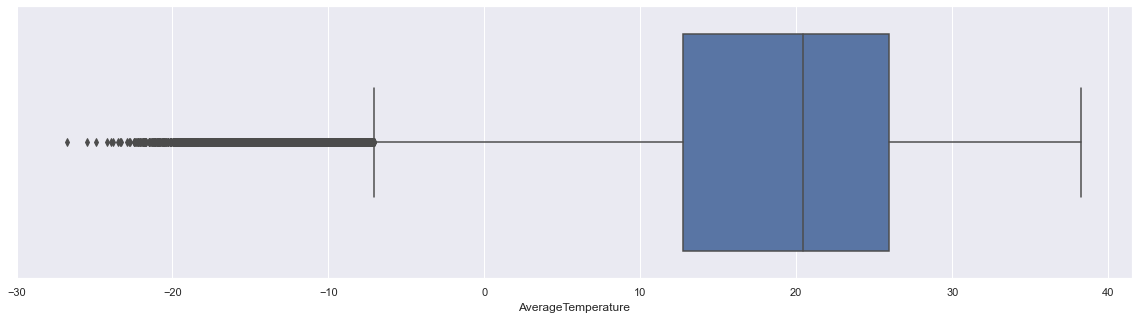

In [10]:
df['date'] = pd.to_datetime(df['dt'])
ax = sns.boxplot(x=df.index, data=df['AverageTemperature'])

In [11]:
# with mean
df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].mean())

In [12]:
# with median
df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].median())

In [13]:
# with most frequent (mode)
df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].value_counts().index[0])

In [14]:
# with zeros
df['AverageTemperature'] = df['AverageTemperature'].fillna(0)

In [15]:
# with any value that much different from existed temperatures 
#df['AverageTemperature'] = df['AverageTemperature'].fillna(500)

# with predicted values
# XGBoost or similar models can be used to predict null values.

# do nothing or drop records with nulls
# Sometimes missing values are not applicable and imputing them is meaningless.

There is also a common option to replace missing values with 0 or with any constant value way more different from existing in a given feature. It’s not always appropriate to fill nulls with 0 as there could be some zero values already (like in this example with temperature) and that would just mean a piece of wrong information.

If you have a large dataset and a little number of rows with nulls, it might be fine to remove these rows at all. Otherwise, there is also an option to predict missing values, and at this point, you should ask yourself if it is worth trying so (in the matter of time and efficiency). In our example let’s go for the median option.

In [16]:

df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].median())

AverageTemperature fluctuation over years:

<AxesSubplot:xlabel='date', ylabel='AverageTemperature'>

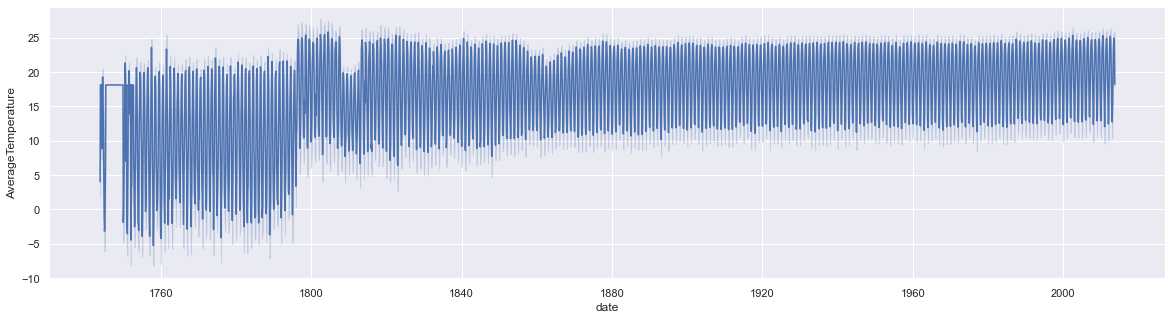

In [17]:
sns.lineplot(x=df['date'], y=df["AverageTemperature"])

<H3>3. Transforming Numerical Features</H3>

In the example dataset, AverageTemperature is a continuous feature because its value can assume any value from the set of real numbers. The option is to make it be more discrete – to create classes for several temperature ranges.

In [18]:
# floats to ints
df['AverageTemperature_int'] = df['AverageTemperature'].astype(int) 

In [19]:
# round numbers
df['AverageTemperature_rounded'] = df['AverageTemperature'].round(1) 


In [20]:
# scale with MinMaxScaler
scaler = MinMaxScaler()
df['AverageTemperature_minmax'] = scaler.fit_transform(df[['AverageTemperature']]) 

In [21]:
# scale with StandardScaler
scaler = StandardScaler()
df['AverageTemperature_standard'] = scaler.fit_transform(df[['AverageTemperature']])

# kmeans **
kmeans = KMeans(n_clusters=10, random_state=0).fit(df[['AverageTemperature']])
df['AverageTemperature_kmeans'] = kmeans.labels_

# kbins **
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(df[['AverageTemperature']])
df['AverageTemperature_kbins'] = est.transform(df[['AverageTemperature']])

# log transformation
max_negative = abs(min(df['AverageTemperature']))
df['AverageTemperature_log'] = df['AverageTemperature'].apply(lambda x: x + max_negative + 0.001).replace(0, 0.001)
df["AverageTemperature_log"] = np.log(df['AverageTemperature_log'])

# ** use Silhouette Coefficient or Elbow method to estimate the optimum number of clusters

The easy way is to convert your floats to ints, or round it by some decimal. Another way to make classes out of feature values is to apply quantization methods like K-means. One is dividing values into k clusters in which each value belongs to the cluster with the nearest mean, and another just binning continuous data into k intervals.

These methods help to change the distribution of initial values which might be useful for example to fix outliers problems. The k number of clusters/bins sometimes can be complicated to choose from, in such cases, one might use the [Silhouette coefficient](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) or [Elbow method](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) to find an optimal k value. Another way of numerical feature transformation is scaling. When your features are in different scales it is a good practice to transform them all into one scale.

In such case units of the model, coefficients are going to be the same, therefore they all bring equal contribution into the analysis. Scaling could also fasten the convergence and show a better performance. One more popular technique to change your feature in a meaningful way is a log transformation. It is used to transform skewed data to make it looks more like a normal distribution.


Before log transformation:

/home/ken/github9000/Experiments-2/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


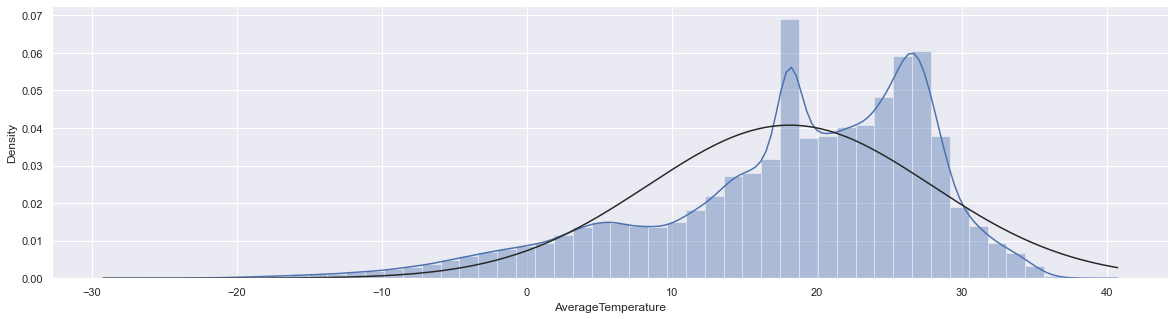

<Figure size 1440x360 with 0 Axes>

In [22]:
from scipy import stats

sns.distplot(df["AverageTemperature"], fit=stats.norm)
fig = plt.figure()


And after:

/home/ken/github9000/Experiments-2/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


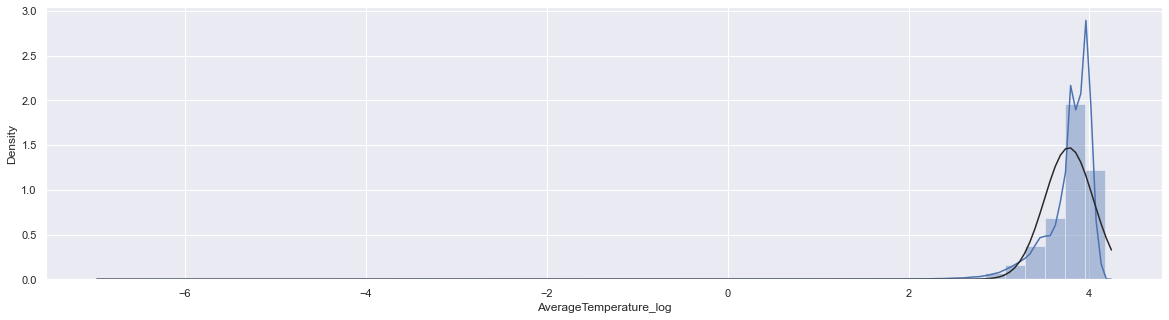

<Figure size 1440x360 with 0 Axes>

In [23]:
sns.distplot(df["AverageTemperature_log"], fit=stats.norm)
fig = plt.figure()

If you noticed the scaling results are not satisfactory, check the distributions of the data again to come up with a better method for feature scaling. Once you did a means or similar technique to reduce the number of unique values in a feature, you might want to proceed with further encoding e.g., create dummies:

Then you might want to continue working with this kmeans transformation, for example, to encode it or to create more discrete values range, it can be done by:



In [24]:
# onehotencoder (get dummies)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['AverageTemperature_kbins']])
col_names = ['AverageTemperature_' + str(i) for i in range(len(np.unique(df['AverageTemperature_kbins'])))]
df[col_names] = enc.transform(df[['AverageTemperature_kbins']]).toarray()

# binary
df['AverageTemperature_hot_cold'] = df['AverageTemperature'].apply(lambda x: 'hot' if x > 10 else 'cold')

In [25]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,date,AverageTemperature_int,AverageTemperature_rounded,...,AverageTemperature_1,AverageTemperature_2,AverageTemperature_3,AverageTemperature_4,AverageTemperature_5,AverageTemperature_6,AverageTemperature_7,AverageTemperature_8,AverageTemperature_9,AverageTemperature_hot_cold
0,1849-01-01,26.704000,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-01-01,26,26.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
1,1849-02-01,27.434000,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-02-01,27,27.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
2,1849-03-01,28.101000,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-03-01,28,28.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
3,1849-04-01,26.140000,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-04-01,26,26.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
4,1849-05-01,25.427000,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-05-01,25,25.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239172,2013-05-01,18.979000,0.807,Xian,China,34.56N,108.97E,2013-05-01,18,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot
239173,2013-06-01,23.522000,0.647,Xian,China,34.56N,108.97E,2013-06-01,23,23.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot
239174,2013-07-01,25.251000,1.042,Xian,China,34.56N,108.97E,2013-07-01,25,25.3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot
239175,2013-08-01,24.528000,0.840,Xian,China,34.56N,108.97E,2013-08-01,24,24.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot


One hot encoding helps to make your classes be equal for the model by creating a binary feature per each (so that a model would not be able to assign more importance to class number 100 than to class number 1). Or just simply binarize your feature or make two labels only, although it reduces a lot of information, in some cases, it might be helpful.



<H3>4. Datetime feature transformations</H3>



Datetime is a common type of feature that can be transformed in different ways, so let’s first look at its ‘date’ part.

<H4>Date</H4>

The most efficient way to transform data into something meaningful might be to divide it into the year, season, month, week, and day. Furthermore, a day could be defined as a day of the year, day of the week, or month. It can be a weekend day, holiday, or just the usual working day. Here you should be aware that in each country/hemisphere these weekends/holidays/seasons may vary and it might not be a good idea to apply one rule to all the countries.

In [26]:
# number of month in a year
df['month_of_year'] = df['date'].dt.month

# number of week in the year
df['week_of_year'] = df['date'].dt.isocalendar().week

# number of the day in the week ***
df['day_of_year'] = df['date'].dt.dayofyear

# season ***
def get_season(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='01/03/'+year, end='31/05/'+year),
               'summer': pd.date_range(start='01/06/'+year, end='31/08/'+year),
               'autumn': pd.date_range(start='01/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'
df['season'] = df.date.map(get_season)

# day of the week ***
df['day_of_week'] = df['date'].dt.day_name()

# weekends ***
df['weekend'] = df['date'].dt.dayofweek

# holidays ***
cal = calendar()
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())
df['holiday'] = df['date'].isin(holidays)


# NOTE: *** day of week, seasons, weekends and holidays vary in different hemispheres and countries.

<H4>Time</H4>

Time can also be separated into hours/minutes/seconds/etc and to which units to convert depends on the specifics of your dataset. Hours can also be defined as a part of a day, meaning that it can be a binary feature with two Day/Night values or it can consist of more labels as in the example:

Lets generate sample times to observe possible transformations:

In [27]:
times = datetime.now().replace(microsecond=0)
df['time'] = pd.Series(pd.date_range(times, periods = len(df) , freq='37T')).dt.time

In [28]:
# hour
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# part of day
df['part_of_day'] = (df['hour'] % 24 + 4) // 4
df['part_of_day'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

# total minutes
df['minute'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.minute + (df['hour'] * 60)

# time to sin/cos
minutes = 24*60
df['sin'] = np.sin(2*np.pi*df['minute']/minutes)
df['cos'] = np.cos(2*np.pi*df['minute']/minutes)

Another stunning time transformation (that can be applied to any circular features) is to convert time to sin and cos. Though it creates two features in exchange for one, it still can be useful when taking into account the difference in time between the end of one day and the start of another day (with sin-cos features there will not be a gap as it is between 23 hour and 00 hour next day).

In [29]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,date,AverageTemperature_int,AverageTemperature_rounded,...,season,day_of_week,weekend,holiday,time,hour,part_of_day,minute,sin,cos
0,1849-01-01,26.704000,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-01-01,26,26.7,...,winter,Monday,0,True,23:24:00,23,Night,1404,-0.156434,0.987688
1,1849-02-01,27.434000,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-02-01,27,27.4,...,spring,Thursday,3,False,00:01:00,0,Late Night,1,0.004363,0.999990
2,1849-03-01,28.101000,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-03-01,28,28.1,...,spring,Thursday,3,False,00:38:00,0,Late Night,38,0.165048,0.986286
3,1849-04-01,26.140000,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-04-01,26,26.1,...,spring,Sunday,6,False,01:15:00,1,Late Night,75,0.321439,0.946930
4,1849-05-01,25.427000,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-05-01,25,25.4,...,spring,Tuesday,1,False,01:52:00,1,Late Night,112,0.469472,0.882948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239172,2013-05-01,18.979000,0.807,Xian,China,34.56N,108.97E,2013-05-01,18,19.0,...,spring,Wednesday,2,False,08:48:00,8,Morning,528,0.743145,-0.669131
239173,2013-06-01,23.522000,0.647,Xian,China,34.56N,108.97E,2013-06-01,23,23.5,...,summer,Saturday,5,False,09:25:00,9,Morning,565,0.625923,-0.779884
239174,2013-07-01,25.251000,1.042,Xian,China,34.56N,108.97E,2013-07-01,25,25.3,...,summer,Monday,0,False,10:02:00,10,Morning,602,0.492424,-0.870356
239175,2013-08-01,24.528000,0.840,Xian,China,34.56N,108.97E,2013-08-01,24,24.5,...,summer,Thursday,3,False,10:39:00,10,Morning,639,0.346117,-0.938191


<AxesSubplot:ylabel='sin'>

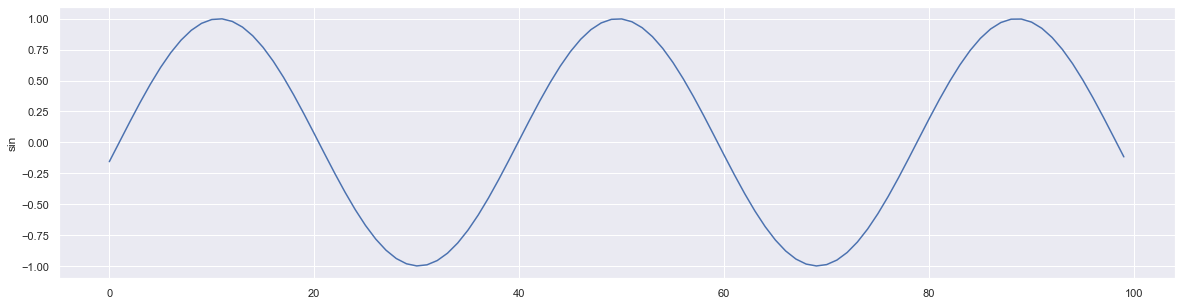

In [30]:
sns.lineplot(data=df['sin'][:100])

<AxesSubplot:ylabel='cos'>

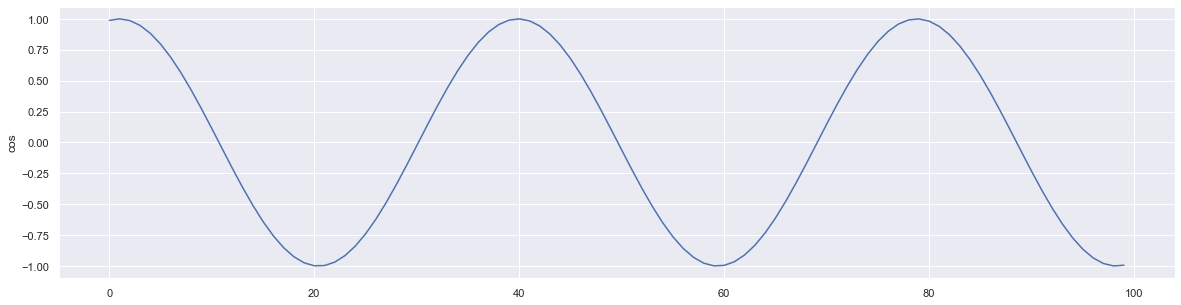

In [31]:
sns.lineplot(data=df['cos'][:100])

<AxesSubplot:xlabel='sin', ylabel='cos'>

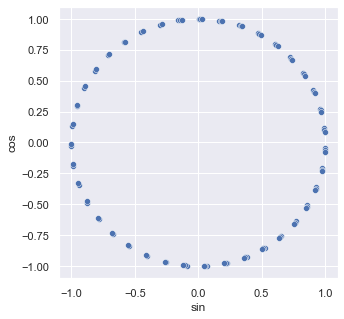

In [32]:
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(data=df[['sin', 'cos']][:100], x="sin", y="cos")

<H3>5. Geographical feature transformations</H3>

Geolocation can be presented in many different ways, but here let’s show the most common option with latitude and longitude, given that in the dataset it is presented in latitude N/S and longitude E/W form (e.g. 5.63N, 3.23W).

In [33]:
# convert to standard latitude & longitude
df['lat'] = df['Latitude'].apply(lambda coord: float(coord.replace('N', '')) if 'N' in coord else -float(coord.replace('S', '')))
df['lng'] = df['Longitude'].apply(lambda coord: float(coord.replace('E', '')) if 'E' in coord else -float(coord.replace('W', '')))

# transform to UTM form
myProj = Proj("+proj=utm +zone=23 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
df['UTMx'], df['UTMy'] = myProj(df['lng'].values, df['lat'].values)

# transform to Web Mercator EPSG:3857
df['EPSG_3857'] = list(zip(df.lat,df.lng))
TRAN_4326_TO_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857")
df['EPSG_3857'] = df['EPSG_3857'].apply(lambda i: TRAN_4326_TO_3857.transform(i[0], i[1]))
df['lat_3857'], df['lng_3857'] = zip(*list(df['EPSG_3857']))

# obtain address
# get adress/postcode/name info via GeoPy ****

# transform to polygons/points
# use GDAL osgeo package

First, you might want to convert these coordinates to standard form (meaning that they become numerical, which is good). And afterward, there is a huge range of different projections and coordinates variations you might be interested in. You might consider one of those is the most suitable in your case, but in the most general way, you would only use the web Mercator form.

Another useful transformation is to obtain an address from your coordinates, which might include country name, city, street, house, name of the place, postcode, and other things. Sometimes you might need to create a zone of locations and therefore you transform your coordinates to polygons and points of polygons.

More info can be found [here](https://towardsdatascience.com/reverse-geocoding-in-python-a915acf29eb6)

In [34]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,date,AverageTemperature_int,AverageTemperature_rounded,...,minute,sin,cos,lat,lng,UTMx,UTMy,EPSG_3857,lat_3857,lng_3857
0,1849-01-01,26.704000,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-01-01,26,26.7,...,1404,-0.156434,0.987688,5.63,-3.23,5.592044e+06,1.083446e+07,"(-359561.9552622736, 627739.7302061031)",-3.595620e+05,6.277397e+05
1,1849-02-01,27.434000,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-02-01,27,27.4,...,1,0.004363,0.999990,5.63,-3.23,5.592044e+06,1.083446e+07,"(-359561.9552622736, 627739.7302061031)",-3.595620e+05,6.277397e+05
2,1849-03-01,28.101000,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-03-01,28,28.1,...,38,0.165048,0.986286,5.63,-3.23,5.592044e+06,1.083446e+07,"(-359561.9552622736, 627739.7302061031)",-3.595620e+05,6.277397e+05
3,1849-04-01,26.140000,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-04-01,26,26.1,...,75,0.321439,0.946930,5.63,-3.23,5.592044e+06,1.083446e+07,"(-359561.9552622736, 627739.7302061031)",-3.595620e+05,6.277397e+05
4,1849-05-01,25.427000,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-05-01,25,25.4,...,112,0.469472,0.882948,5.63,-3.23,5.592044e+06,1.083446e+07,"(-359561.9552622736, 627739.7302061031)",-3.595620e+05,6.277397e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239172,2013-05-01,18.979000,0.807,Xian,China,34.56N,108.97E,2013-05-01,18,19.0,...,528,0.743145,-0.669131,34.56,108.97,2.915961e+06,2.584701e+07,"(12130484.91174302, 4104246.5068497662)",1.213048e+07,4.104247e+06
239173,2013-06-01,23.522000,0.647,Xian,China,34.56N,108.97E,2013-06-01,23,23.5,...,565,0.625923,-0.779884,34.56,108.97,2.915961e+06,2.584701e+07,"(12130484.91174302, 4104246.5068497662)",1.213048e+07,4.104247e+06
239174,2013-07-01,25.251000,1.042,Xian,China,34.56N,108.97E,2013-07-01,25,25.3,...,602,0.492424,-0.870356,34.56,108.97,2.915961e+06,2.584701e+07,"(12130484.91174302, 4104246.5068497662)",1.213048e+07,4.104247e+06
239175,2013-08-01,24.528000,0.840,Xian,China,34.56N,108.97E,2013-08-01,24,24.5,...,639,0.346117,-0.938191,34.56,108.97,2.915961e+06,2.584701e+07,"(12130484.91174302, 4104246.5068497662)",1.213048e+07,4.104247e+06


<H3>6. Text feature transformations</H3>

One of the most common feature representations is a text. It could be plain text, just some phrases, words, or any structured and unstructured number of characters. For example, in the observed dataset, there is a Country column consists of country names. What could be done about it? Not much in our case as this column is more about labels than the text itself, but still, you might notice the names in the Country column are not all in the English language (e.g. Côte D’Ivoire country name), and, for example, you might want to have all your records in one language.

So that would be a good transformation – to translate all country words to one language. For more complicated cases you might want to use regex and NLP methods to deal with textual data.


In [35]:
# translate all countries to english
translator = google_translator() 

# Known translate error:  
# https://stackoverflow.com/questions/68214591/python-google-trans-new-translate-raises-error-jsondecodeerror-extra-data

#for c in np.unique(df['Country']):
#    print('=> ', c[:-1])
#
#
#countries_en = [np.unique(df['Country'])]
#for c in countries_en:
#    print(translator.translate(c, lang_tgt='en')[:-1])


countries_en = [translator.translate(c)[:-1] for c in np.unique(df['Country'])]
countries_en = dict(ChainMap(*[{c1:c2} for c1,c2 in zip(np.unique(df['Country']),countries_en) if c1 != c2]))
df['country_en'] = df['Country'].replace(countries_en)

# convert to numeric column (labelencoding)
df['country_code'] = df['country_en'].astype('category').cat.codes



# bigger texts can be transformed in many ways
# use NLP for your purposes

JSONDecodeError: Extra data: line 1 column 239 (char 238)

We went through the most common feature types you might face in your day-to-day routine and suggested a good practice to manage transformation for such features. This cheatsheet is a reminder that there are plenty of ways of converting features to some efficient useful information and it is better not to stick to one and only transformation with different models, but to look at the transformation from different sides.